<a href="https://colab.research.google.com/github/rachboyle/mixed_methods_b2b_personas_generation/blob/main/conf_survey_data_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Survey Data and Initial Clustering

In [1]:
#Authenticate to GCP to access survey and web analytics data in BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


##Iterative Mixed Method Approach to B2B SaaS User Personas Overview
Below is an overview of the various analysis and clustering steps we took for our persona generation research. This particular notebook focuses on the step(s) highlighted in yellow: 

1.   <mark> **Survey Data Pre-Processing**: Survey data cleaning and pre-processing
2.   <mark> **Survey Clustering**: Initial survey clustering to produce rudimentary personas we could use for interview recruitment
3.   **Analytcs Data Pre-Processing**: Web analytics data (from [Pendo](https://www.pendo.io) tool) pre-processing, manipulation, and sanitization tool
4.   **Preprocessing and Clustering Iterations**: Four iterations of preprocessing and clustering on the web analytics data; the following iterations listed below contain the clustering algorithm, dimensionality reduction method, and data pre-processing manipulation respectively
    * *KMeans, PCA, Averaged Data*
    * *KMeans, PCA, Percentage Usage Data Per Day*
    * *KMeans, UMAP, Percentage Usage Data Per Day*
    * *HDBScan, UMAP, Percentage Usage Data Per Week*







##Imports

In [2]:
#Install UMAP (dimensionality reduction) and HDBscan (clustering algorithm)
!pip install umap-learn
!pip install hdbscan

     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 11.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=e716b9cab09e7966d33b34a84457f914a4abfa79d23ecbcfd08f2611c0cd6a2f
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=7e2b5f049f9fe33a69847bb186c8970453cb2022048efe184d4115e9df2fc753
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
     |████████████████████████████████| 5.2 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330766 sha256=7a5e4d4037f65bdf05188fd4193a

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import display_html
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.rcParams.update({'figure.max_open_warning': 0}) #set so you do not get warnings

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize, StandardScaler

##Survey Data Pre-Processing
We administered the survey via qualtrics which has several export as CSV options. The ones we selected and were important in helping to diminsh data manipulation steps, faciliate easier data interpretation, and enable compatibility with downstream actions like clustering were:
1. downloading fields as numerical values rather than choice text, 
2. recoding seen but unanswered questions as -99, 
3. recoding seen but unanswered multi-value fields as 0,
3. remove line breaks,
4. split multi-value fields into columns
5. remove line breaks

The main goals with survey data pre-processing were to identify the questions / responses we wanted to base our clustering on, sanitize out responses that were not significantly completed, and restructure the data into a format suitable for clustering algorithms from existing packages like sklearn.  

From analyzing the data results within the qualtrics app, we determined that task rank and time on task were the data points we wanted to use as features in preliminary clustering. 

Raw Survey Data

In [9]:
#Showing the original raw survey data 
sheet_id = "17S9byy_6Gtw8IsEvybeHY8OkGDB4jSdcwukQrWtzo08"
sheet_name = "survey_responses"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

raw_survey_df = pd.read_csv(url)

raw_survey_df.head(3)

,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,What LiveRamp products do you personally use. (select all that apply) - Connect/Activation,What LiveRamp products do you personally use. (select all that apply) - Connect/Measurement,What LiveRamp products do you personally use. (select all that apply) - Advanced TV,...,Which of the following best describe your current occupation? - Selected Choice,Which of the following best describe your current occupation? - Other (please specify) - Text,Which of these best describes your seniority at work?,"Do you use any accessibility features, such as the following? - Selected Choice","Do you use any accessibility features, such as the following? - Other (please specify) - Text","Thinking about everything that you use LiveRamp for and your reasons for choosing LiveRamp, what three words would you use to describe how using LiveRamp makes you feel? - Word 1","Thinking about everything that you use LiveRamp for and your reasons for choosing LiveRamp, what three words would you use to describe how using LiveRamp makes you feel? - Word 2","Thinking about everything that you use LiveRamp for and your reasons for choosing LiveRamp, what three words would you use to describe how using LiveRamp makes you feel? - Word 3",Company name,"As a thank-you for taking part, you will be entered into a prize draw to win one of three prizes: A $200 Amazon e-gift card, and two $100 Amazon e-gift cards. Entry is optional and full terms and conditions for the prize draw can be viewed here."
0,2021-06-25 14:18:26,2021-06-25 14:23:08,0.0,100.0,282.0,1.0,2021-06-25 14:23:09,0.0,0.0,0.0,...,11.0,-99.0,3.0,4.0,-99.0,-99,-99,-99,***,4.0
1,2021-06-25 14:20:18,2021-06-25 14:27:55,0.0,100.0,456.0,1.0,2021-06-25 14:27:55,1.0,1.0,0.0,...,11.0,-99.0,3.0,4.0,-99.0,Disappointed,Good UI,Tedious,***,4.0
2,2021-06-25 14:20:58,2021-06-25 14:29:19,0.0,100.0,500.0,1.0,2021-06-25 14:29:19,0.0,0.0,0.0,...,5.0,-99.0,2.0,4.0,-99.0,-99,-99,-99,***,4.0


In [11]:
#Showing the total number of columns and examples of the questions
print(raw_survey_df.columns)

Index(['Start Date', 'End Date', 'Response Type', 'Progress',
       'Duration (in seconds)', 'Finished', 'Recorded Date',
       'What LiveRamp products do you personally use. (select all that apply) - Connect/Activation',
       'What LiveRamp products do you personally use. (select all that apply) - Connect/Measurement',
       'What LiveRamp products do you personally use. (select all that apply) - Advanced TV',
       ...
       'Which of the following best describe your current occupation? - Selected Choice',
       'Which of the following best describe your current occupation? - Other (please specify) - Text',
       'Which of these best describes your seniority at work?',
       'Do you use any accessibility features, such as the following? - Selected Choice',
       'Do you use any accessibility features, such as the following? - Other (please specify) - Text',
       'Thinking about everything that you use LiveRamp for and your reasons for choosing LiveRamp, what three words 

Manipulated Survey Data: 
* reformatted column names for easier interpretability, especially for multi select questions, 
* mapped row values for easier downstream computation 
    * i.e. For the question "How long do you spend on task XYZ?" responses are NUMBERS representing different choices such as 1 - 5 mins, 2 - 10 mins, 3 - 15 mins, etc. Converted all responses to true numerical values 1 --> 5, 2 --> 10, 3 --> 15, etc.   
* selected only questions, and therefore columns, of interest
* sanitized survey responses that were uncompleted

In [ ]:
%%bigquery --project uxr-design-us-dev task_rank_df
SELECT -- ReceipientEmail is not included for anonymity
-- grab the columns on users ranking the priority of identified tasks in our platform
task_rank_build_audience, task_rank_usage_reports, task_rank_lsh_lookalike, task_rank_add_users, task_rank_set_permissions, 
task_rank_data_ingestion, task_rank_dm_upload, task_rank_manage_data, task_rank_manage_das, task_rank_distribute, task_rank_understand_reach, 
task_rank_request_dm_segments, task_rank_sql_queries, task_rank_data_vis, task_rank_use_ats, task_rank_help_docs, task_rank_support_tix, 
-- grab the columns on users self-attesting to time spent on identified tasks per day
task_time_per_day_build_audience, task_time_per_day_usage_reports, task_time_per_day_lsh_lookalike, task_time_per_day_add_users, task_time_per_day_set_permissions, 
task_time_per_day_data_ingestion,task_time_per_day_dm_upload, task_time_per_day_manage_data, task_time_per_day_manage_das, task_time_per_day_distribute,task_time_per_day_understand_reach, 
task_time_per_day_request_dm_segments, task_time_per_day_sql_queries, task_time_per_day_data_vis, task_time_per_day_use_ats, task_time_per_day_help_docs, task_time_per_day_support_tix, 
FROM `uxr-design-us-dev.persona_study_2021.raw_survey_data_multiselect_numerical_columns_07272021`

In [ ]:
#Grab column names to use a features in clustering
features = task_rank_df.columns.tolist()
rank = features[0:len(features)//2] #first half of columns relate to rank
time = features[len(features)//2::] #second half of columns relate to time

assert (len(rank) == len(time))
assert len(features) == len(rank) + len(time) 

In [ ]:
#Function that checks to see if all the values in a row of a df are ints
def is_all_ints(row):
  int_count = 0
  str_count = 0
  # int_values = []
  # str_values = []
  for value in row:
    if type(value) == int:
      # if value not in int_values:
      #   int_values.append(value)
      int_count += 1
    elif type(value) == str:
      # if value not in str_values:
      #   str_values.append(value)
      str_count += 1
  if int_count == 0 & str_count == 0:
      # print("No ints or strs, but: " + str(type(value)))
      return False
  else:
    # print("int:" + str(int_count) + "\nint value:" + str(int_value) + "\nstr:" + str(str_count))
    return len(row) == int_count
    
#Manipulate Survey Data into Best Form for Clustering
def manipulate_df(df):
  #Fill Nulls with 0s and change data type to int
  df = df.fillna(0)

  #Cast numbers as int in order to perform the replacing functions below
  df = df.astype(int)

  #Santize data of entries user made no selection
  df["rank_nulls"] = (df[rank] == 0).sum(axis = 1)
  df["time_nulls"] = (df[time] == 0).sum(axis = 1)
  filled_df = df[(df.time_nulls != len(time)) & (df.rank_nulls != len(rank))].copy()
  filled_df.drop(["rank_nulls", "time_nulls"], axis=1) #Added to remove an unnecessary column

  #Grab the counts of numerical response before converting to minutes
  pre_cnt_0 = (filled_df.task_time_per_day_build_audience == 0).sum(axis=0)
  pre_cnt_1 = (filled_df.task_time_per_day_build_audience == 1).sum(axis=0)
  pre_cnt_2 = (filled_df.task_time_per_day_build_audience == 2).sum(axis=0)
  pre_cnt_3 = (filled_df.task_time_per_day_build_audience == 3).sum(axis=0)
  pre_cnt_4 = (filled_df.task_time_per_day_build_audience == 4).sum(axis=0)
  pre_cnt_5 = (filled_df.task_time_per_day_build_audience == 5).sum(axis=0)
  pre_cnt_6 = (filled_df.task_time_per_day_build_audience == 6).sum(axis=0)
  pre_cnt_7 = (filled_df.task_time_per_day_build_audience == 7).sum(axis=0)
  pre_total_cnt = filled_df.task_time_per_day_build_audience.count()

  #Manipuate column and change from categorical data to numerical values of time (mins) on task
  for col in time: 
    filled_df[col].replace(1, 5.5, inplace=True)
    filled_df[col].replace(2, 15, inplace=True)
    filled_df[col].replace(3, 25, inplace=True)
    filled_df[col].replace(4, 35, inplace=True)
    filled_df[col].replace(5, 45, inplace=True)
    filled_df[col].replace(6, 55, inplace=True)
    filled_df[col].replace(7, 65, inplace=True)

  #Grab the counts of numerical response after converting to minutes
  post_cnt_0 = (filled_df.task_time_per_day_build_audience == 0).sum(axis=0)
  post_cnt_1 = (filled_df.task_time_per_day_build_audience == 5.5).sum(axis=0)
  post_cnt_2 = (filled_df.task_time_per_day_build_audience == 15).sum(axis=0)
  post_cnt_3 = (filled_df.task_time_per_day_build_audience == 25).sum(axis=0)
  post_cnt_4 = (filled_df.task_time_per_day_build_audience == 35).sum(axis=0)
  post_cnt_5 = (filled_df.task_time_per_day_build_audience == 45).sum(axis=0)
  post_cnt_6 = (filled_df.task_time_per_day_build_audience == 55).sum(axis=0)
  post_cnt_7 = (filled_df.task_time_per_day_build_audience == 65).sum(axis=0)
  post_total_cnt = filled_df.task_time_per_day_build_audience.count()

  #Check the counts are equivalent before and after conversion
  assert pre_cnt_0 == post_cnt_0
  assert pre_cnt_1 == post_cnt_1
  assert pre_cnt_2 == post_cnt_2
  assert pre_cnt_3 == post_cnt_3
  assert pre_cnt_4 == post_cnt_4
  assert pre_cnt_5 == post_cnt_5
  assert pre_cnt_6 == post_cnt_6
  assert pre_cnt_7 == post_cnt_7
  assert pre_total_cnt == post_total_cnt

  for r in rank:
    assert is_all_ints(filled_df[r]) is True 

  #Replace zero values with max rank for all rank task columns to keep directionality of rank (1- highest rank, 24- lowest rank)
  for col in rank: 
    filled_df[col].replace(0, len(rank), inplace=True)

  return filled_df

In [ ]:
#Showing the manipulated survey data
survey_df = manipulate_df(task_rank_df)
survey_df.head()

,task_rank_build_audience,task_rank_usage_reports,task_rank_lsh_lookalike,task_rank_add_users,task_rank_set_permissions,task_rank_data_ingestion,task_rank_dm_upload,task_rank_manage_data,task_rank_manage_das,task_rank_distribute,task_rank_understand_reach,task_rank_request_dm_segments,task_rank_sql_queries,task_rank_data_vis,task_rank_use_ats,task_rank_help_docs,task_rank_support_tix,task_time_per_day_build_audience,task_time_per_day_usage_reports,task_time_per_day_lsh_lookalike,task_time_per_day_add_users,task_time_per_day_set_permissions,task_time_per_day_data_ingestion,task_time_per_day_dm_upload,task_time_per_day_manage_data,task_time_per_day_manage_das,task_time_per_day_distribute,task_time_per_day_understand_reach,task_time_per_day_request_dm_segments,task_time_per_day_sql_queries,task_time_per_day_data_vis,task_time_per_day_use_ats,task_time_per_day_help_docs,task_time_per_day_support_tix,rank_nulls,time_nulls
69,7,5,17,9,17,6,17,3,4,2,1,17,17,17,17,8,17,5.5,5.5,0.0,5.5,0.0,5.5,0.0,5.5,5.5,5.5,5.5,0.0,0.0,0.0,0.0,5.5,0.0,8,8
72,17,17,17,17,17,1,17,17,17,17,17,17,17,17,17,17,17,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,16
75,2,17,17,17,17,1,17,3,17,17,17,17,17,17,17,17,17,5.5,0.0,0.0,0.0,0.0,5.5,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,14
81,3,17,17,17,17,1,17,17,17,2,17,17,17,17,17,17,17,55.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,14
83,3,17,17,17,17,4,17,17,17,1,2,17,17,17,17,17,17,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,13,13


##Survey Data Clustering

In [ ]:
#import modules for clustering and plotting
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm 
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
plt.rcParams.update({'figure.max_open_warning': 0}) #set so you do not get warnings

In [ ]:
#Make a copy of the data to perform the transformations and normalization on
X = survey_df[rank].copy()

#Use the standard scaler algorithm to normalize the data
scaler = StandardScaler()
X[rank] = scaler.fit_transform(X[rank])

,task_rank_build_audience,task_rank_usage_reports,task_rank_lsh_lookalike,task_rank_add_users,task_rank_set_permissions,task_rank_data_ingestion,task_rank_dm_upload,task_rank_manage_data,task_rank_manage_das,task_rank_distribute,task_rank_understand_reach,task_rank_request_dm_segments,task_rank_sql_queries,task_rank_data_vis,task_rank_use_ats,task_rank_help_docs,task_rank_support_tix
69,0.323730,-1.495895,0.228457,-0.575760,0.440196,-0.254494,0.679458,-1.524542,-0.845098,-0.588322,-2.342034,0.550920,0.258902,0.251660,0.241045,-1.083487,0.774615
72,2.017893,0.635394,0.228457,0.774659,0.440196,-0.945645,0.679458,0.787232,1.143996,1.875754,0.600120,0.550920,0.258902,0.251660,0.241045,0.716124,0.774615
75,-0.523352,0.635394,0.228457,0.774659,0.440196,-0.945645,0.679458,-1.524542,1.143996,1.875754,0.600120,0.550920,0.258902,0.251660,0.241045,0.716124,0.774615
81,-0.353936,0.635394,0.228457,0.774659,0.440196,-0.945645,0.679458,0.787232,1.143996,-0.588322,0.600120,0.550920,0.258902,0.251660,0.241045,0.716124,0.774615
83,-0.353936,0.635394,0.228457,0.774659,0.440196,-0.530954,0.679458,0.787232,1.143996,-0.752594,-2.158150,0.550920,0.258902,0.251660,0.241045,0.716124,0.774615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,-0.184519,-0.785465,0.228457,-1.082168,-1.612284,-0.392724,-1.009368,-1.524542,-1.151113,-0.752594,-0.687073,0.054515,-1.745002,-1.341674,0.241045,0.316211,-0.173443
475,-0.523352,-0.963073,0.228457,-0.406958,-0.472017,-0.945645,-1.178251,-1.194288,-0.080062,-0.424050,-1.790380,-1.103765,0.258902,0.251660,0.241045,-0.483616,-0.173443
476,-0.692769,0.635394,0.228457,-1.588575,-2.524497,1.266039,-1.009368,-0.698908,-0.080062,0.725852,-0.503188,-1.931107,0.258902,0.251660,0.241045,-0.083703,-0.173443
477,-0.692769,-1.140680,0.228457,-0.238155,-1.156177,-0.392724,0.679458,-1.029162,-0.233069,-0.424050,-1.790380,0.550920,-4.750858,-2.935009,0.241045,0.716124,0.205780


In [ ]:
#Function that helps find the optimal number of clusters by using the Elbow Method
def plot_elbow_curve(df, title):
  wcss = []
  for k in range(1,20):
      kmeans = KMeans(n_clusters=k, init="k-means++")
      kmeans.fit(df.iloc[:,1:])
      wcss.append(kmeans.inertia_)
  plt.figure(figsize=(12,6))    
  plt.plot(range(1,20),wcss, linewidth=2, color="red", marker ="8")
  plt.grid(True)
  plt.xlabel("K Value")
  plt.xticks(np.arange(1,20,1))
  plt.ylabel("WCSS")
  plt.title(title)
  plt.show()

#Perform K Means clustering and find averages for each cluster
def kmeans_clustering_aves(num, df, cluster_name, features=features):
  kmeans = KMeans(n_clusters=num, init='k-means++', n_init=20)
  y = kmeans.fit_predict(df[features])
  df[cluster_name] = y
  kmeans_summary = df.groupby([cluster_name]).mean()
  kmeans_summary['count'] = df[cluster_name].value_counts()
  kmeans_summary = kmeans_summary.sort_values(by='count', ascending=False)
  # print(kmeans_summary)
  return kmeans_summary

#Plot the averages for each cluster and rank the tasks
def cluster_means_and_plots(kmeans_summary):
  #plot each cluster and calculate averages
  cnt = kmeans_summary['count'].sum() #total number of individuals to understand % of survey respondents in each cluster
  unique_top_tasks = {}
  for cluster_num, row in kmeans_summary.iterrows():
    print("\n")
    print("PERSONA CLUSTER:", cluster_num, "\n")
    print("NUMBER OF PARTICIPANTS IN CLUSTER:", row["count"], "\n")
    print("PERCENTAGE OF PARTICIPANTS IN CLUSTER:", round(100*row["count"]/cnt, 3), "\n") #originall the dividend is 266, changed to be the total
    cluster_df = pd.DataFrame(index = tasks)
    cluster_df.insert(0,"rank", row[rank].values)
    cluster_df.insert(1,"time", row[time].values)
    plt.scatter(cluster_df["rank"], cluster_df["time"], c=colormap) #color for each task
    plt.grid(True)
    plt.xlabel("Rank")
    plt.ylabel("Time")
    plt.show() 

    cluster_df = cluster_df.sort_values(by=["rank"], ascending=True)
    print(cluster_df)

    #keep track of top tasks
    top_tasks = list(cluster_df.head(5).index)
    for top_task in top_tasks:
      if top_task not in unique_top_tasks.keys():
        unique_top_tasks[top_task] = 1
      else:
        unique_top_tasks[top_task] += 1 

  return unique_top_tasks

Dimensionality Reduction via PCA

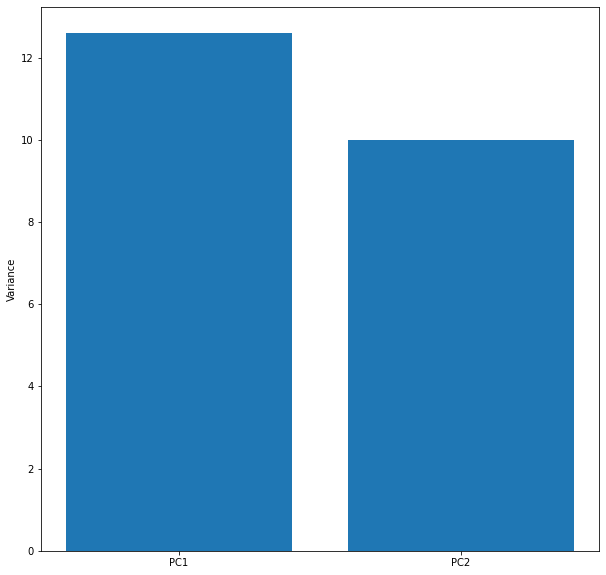

In [ ]:
pca = PCA(n_components=2)
data = pca.fit_transform(X)

plt.figure(figsize=(10,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = ['PC'+ str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.ylabel('Variance')
plt.show()

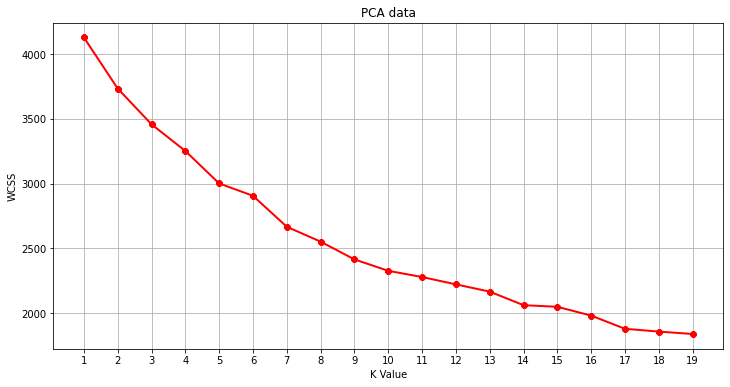

In [ ]:
#Plot the elbow curve to find best value for K means
plot_elbow_curve(X[rank], "PCA data")

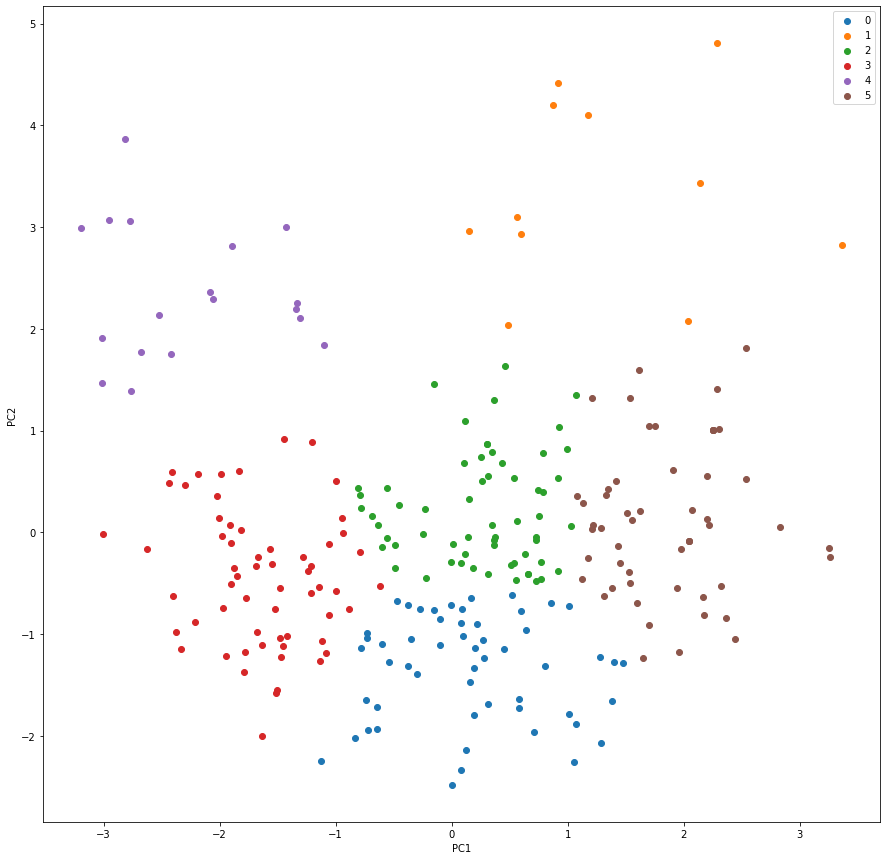

In [ ]:
survey_model = KMeans(n_clusters = 6, init = "k-means++", n_init=20)
survey_label = survey_model.fit_predict(data)

plt.figure(figsize=(15,15))
uniq = np.unique(survey_label)
for i in uniq:
  plt.scatter(data[survey_label == i , 0] , data[survey_label == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [ ]:
cluster_name = "kmeans_pca_cluster"
survey_df[cluster_name] = survey_label
kmeans_summary = survey_df.groupby([cluster_name]).mean()
kmeans_summary['count'] = survey_df[cluster_name].value_counts()
kmeans_summary = kmeans_summary.sort_values(by='count', ascending=False)
kmeans_summary

,task_rank_build_audience,task_rank_usage_reports,task_rank_lsh_lookalike,task_rank_add_users,task_rank_set_permissions,task_rank_data_ingestion,task_rank_dm_upload,task_rank_manage_data,task_rank_manage_das,task_rank_distribute,task_rank_understand_reach,task_rank_request_dm_segments,task_rank_sql_queries,task_rank_data_vis,task_rank_use_ats,task_rank_help_docs,task_rank_support_tix,task_time_per_day_build_audience,task_time_per_day_usage_reports,task_time_per_day_lsh_lookalike,task_time_per_day_add_users,task_time_per_day_set_permissions,task_time_per_day_data_ingestion,task_time_per_day_dm_upload,task_time_per_day_manage_data,task_time_per_day_manage_das,task_time_per_day_distribute,task_time_per_day_understand_reach,task_time_per_day_request_dm_segments,task_time_per_day_sql_queries,task_time_per_day_data_vis,task_time_per_day_use_ats,task_time_per_day_help_docs,task_time_per_day_support_tix,rank_nulls,time_nulls,count
kmeans_pca_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,4.245902,14.213115,16.754098,11.000000,14.754098,6.721311,13.786885,10.950820,10.442623,7.032787,14.918033,16.131148,17.000000,17.000000,16.540984,14.000000,14.721311,16.877049,4.221311,0.245902,6.344262,1.942623,13.721311,4.221311,8.598361,6.516393,13.336066,3.139344,1.975410,0.000000,0.000000,0.180328,4.557377,3.000000,11.983607,11.983607,61
3,6.433333,11.316667,17.000000,10.750000,14.250000,4.016667,10.566667,8.916667,4.633333,2.683333,10.716667,15.983333,16.683333,16.800000,16.100000,10.616667,8.833333,13.233333,7.625000,0.000000,7.141667,4.333333,16.275000,10.900000,14.716667,17.933333,20.958333,8.966667,1.266667,0.666667,0.508333,1.341667,11.841667,13.875000,8.383333,8.383333,60
0,7.111111,13.425926,17.000000,12.203704,16.592593,11.685185,12.722222,16.388889,7.611111,2.407407,13.759259,8.296296,17.000000,17.000000,15.314815,12.962963,11.166667,14.481481,5.453704,0.000000,3.379630,0.564815,5.453704,5.435185,0.481481,10.796296,21.546296,4.509259,12.435185,0.000000,0.000000,2.324074,5.851852,8.564815,11.259259,11.259259,54
5,2.685185,15.425926,16.740741,15.962963,17.000000,10.185185,14.740741,14.962963,15.703704,9.129630,16.703704,12.074074,17.000000,16.777778,16.722222,15.981481,16.740741,19.370370,2.990741,0.277778,2.231481,0.000000,7.870370,2.712963,1.527778,2.509259,9.907407,0.101852,6.175926,0.000000,0.462963,0.101852,1.138889,0.101852,14.000000,14.000000,54
4,4.777778,10.944444,15.833333,11.111111,9.277778,5.222222,12.722222,7.111111,6.111111,3.888889,10.500000,16.500000,9.388889,10.722222,16.833333,12.277778,12.722222,31.472222,9.388889,1.138889,6.305556,7.944444,21.222222,7.027778,25.111111,20.111111,26.444444,20.305556,1.694444,30.611111,28.361111,0.305556,10.777778,9.138889,6.777778,6.777778,18
1,4.818182,14.727273,5.636364,15.000000,13.818182,8.818182,14.636364,12.000000,15.727273,14.272727,14.272727,17.000000,13.000000,14.636364,17.000000,17.000000,15.272727,11.636364,1.863636,14.272727,1.000000,3.227273,15.545455,4.545455,10.045455,0.500000,6.409091,2.772727,0.000000,9.590909,3.636364,0.000000,0.000000,1.000000,12.545455,12.545455,11


In [ ]:
#Splice the columns to just be the task names for plotting purposes
tasks = []
prefix = "task_rank_"
for item in rank:
  tasks.append(item[len(prefix)::])

colormap= cm.rainbow(np.linspace(0, 1, len(tasks)))



PERSONA CLUSTER: 2 

NUMBER OF PARTICIPANTS IN CLUSTER: 61.0 

PERCENTAGE OF PARTICIPANTS IN CLUSTER: 23.643 



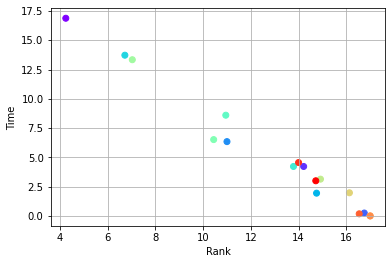

                          rank       time
build_audience        4.245902  16.877049
data_ingestion        6.721311  13.721311
distribute            7.032787  13.336066
manage_das           10.442623   6.516393
manage_data          10.950820   8.598361
add_users            11.000000   6.344262
dm_upload            13.786885   4.221311
help_docs            14.000000   4.557377
usage_reports        14.213115   4.221311
support_tix          14.721311   3.000000
set_permissions      14.754098   1.942623
understand_reach     14.918033   3.139344
request_dm_segments  16.131148   1.975410
use_ats              16.540984   0.180328
lsh_lookalike        16.754098   0.245902
sql_queries          17.000000   0.000000
data_vis             17.000000   0.000000


PERSONA CLUSTER: 3 

NUMBER OF PARTICIPANTS IN CLUSTER: 60.0 

PERCENTAGE OF PARTICIPANTS IN CLUSTER: 23.256 



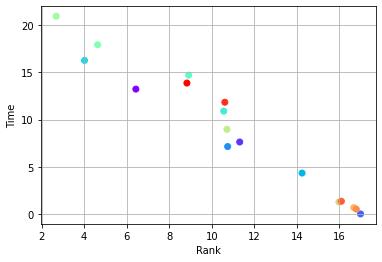

                          rank       time
distribute            2.683333  20.958333
data_ingestion        4.016667  16.275000
manage_das            4.633333  17.933333
build_audience        6.433333  13.233333
support_tix           8.833333  13.875000
manage_data           8.916667  14.716667
dm_upload            10.566667  10.900000
help_docs            10.616667  11.841667
understand_reach     10.716667   8.966667
add_users            10.750000   7.141667
usage_reports        11.316667   7.625000
set_permissions      14.250000   4.333333
request_dm_segments  15.983333   1.266667
use_ats              16.100000   1.341667
sql_queries          16.683333   0.666667
data_vis             16.800000   0.508333
lsh_lookalike        17.000000   0.000000


PERSONA CLUSTER: 0 

NUMBER OF PARTICIPANTS IN CLUSTER: 54.0 

PERCENTAGE OF PARTICIPANTS IN CLUSTER: 20.93 



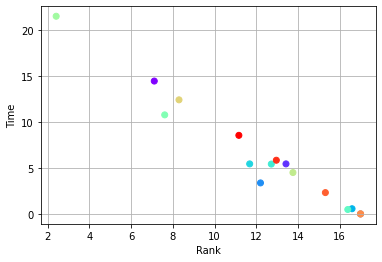

                          rank       time
distribute            2.407407  21.546296
build_audience        7.111111  14.481481
manage_das            7.611111  10.796296
request_dm_segments   8.296296  12.435185
support_tix          11.166667   8.564815
data_ingestion       11.685185   5.453704
add_users            12.203704   3.379630
dm_upload            12.722222   5.435185
help_docs            12.962963   5.851852
usage_reports        13.425926   5.453704
understand_reach     13.759259   4.509259
use_ats              15.314815   2.324074
manage_data          16.388889   0.481481
set_permissions      16.592593   0.564815
sql_queries          17.000000   0.000000
data_vis             17.000000   0.000000
lsh_lookalike        17.000000   0.000000


PERSONA CLUSTER: 5 

NUMBER OF PARTICIPANTS IN CLUSTER: 54.0 

PERCENTAGE OF PARTICIPANTS IN CLUSTER: 20.93 



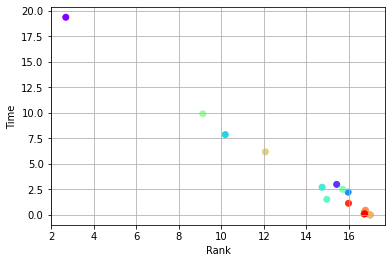

                          rank       time
build_audience        2.685185  19.370370
distribute            9.129630   9.907407
data_ingestion       10.185185   7.870370
request_dm_segments  12.074074   6.175926
dm_upload            14.740741   2.712963
manage_data          14.962963   1.527778
usage_reports        15.425926   2.990741
manage_das           15.703704   2.509259
add_users            15.962963   2.231481
help_docs            15.981481   1.138889
understand_reach     16.703704   0.101852
use_ats              16.722222   0.101852
lsh_lookalike        16.740741   0.277778
support_tix          16.740741   0.101852
data_vis             16.777778   0.462963
sql_queries          17.000000   0.000000
set_permissions      17.000000   0.000000


PERSONA CLUSTER: 4 

NUMBER OF PARTICIPANTS IN CLUSTER: 18.0 

PERCENTAGE OF PARTICIPANTS IN CLUSTER: 6.977 



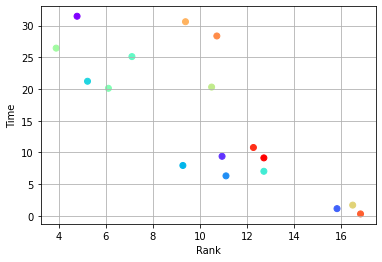

                          rank       time
distribute            3.888889  26.444444
build_audience        4.777778  31.472222
data_ingestion        5.222222  21.222222
manage_das            6.111111  20.111111
manage_data           7.111111  25.111111
set_permissions       9.277778   7.944444
sql_queries           9.388889  30.611111
understand_reach     10.500000  20.305556
data_vis             10.722222  28.361111
usage_reports        10.944444   9.388889
add_users            11.111111   6.305556
help_docs            12.277778  10.777778
dm_upload            12.722222   7.027778
support_tix          12.722222   9.138889
lsh_lookalike        15.833333   1.138889
request_dm_segments  16.500000   1.694444
use_ats              16.833333   0.305556


PERSONA CLUSTER: 1 

NUMBER OF PARTICIPANTS IN CLUSTER: 11.0 

PERCENTAGE OF PARTICIPANTS IN CLUSTER: 4.264 



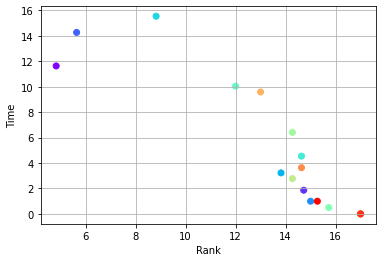

                          rank       time
build_audience        4.818182  11.636364
lsh_lookalike         5.636364  14.272727
data_ingestion        8.818182  15.545455
manage_data          12.000000  10.045455
sql_queries          13.000000   9.590909
set_permissions      13.818182   3.227273
distribute           14.272727   6.409091
understand_reach     14.272727   2.772727
dm_upload            14.636364   4.545455
data_vis             14.636364   3.636364
usage_reports        14.727273   1.863636
add_users            15.000000   1.000000
support_tix          15.272727   1.000000
manage_das           15.727273   0.500000
help_docs            17.000000   0.000000
use_ats              17.000000   0.000000
request_dm_segments  17.000000   0.000000


In [ ]:
top_tasks = cluster_means_and_plots(kmeans_summary)

In [ ]:
#Show the top unique tasks across all clusters
top_tasks

{'build_audience': 6,
 'data_ingestion': 5,
 'distribute': 5,
 'dm_upload': 1,
 'lsh_lookalike': 1,
 'manage_das': 4,
 'manage_data': 3,
 'request_dm_segments': 2,
 'sql_queries': 1,
 'support_tix': 2}